# Explicación del caso

El objetivo de este laboratorio es crear un modelo que pueda predecir la cantidad total de precipitación que llega al suelo en determinado período se expresa en términos de profundidad vertical de agua que cubriría una proyección horizontal de la superficie de la Tierra, se expresa en milímetros (mm). Con el propósito principal para el uso de planificación de riego en la agricultura.

###Librerías a usar

In [41]:
# Importación de librerías
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression   # para modelos de regresion lineal
from sklearn.linear_model import Ridge   # Ridge regression
from sklearn.linear_model import Lasso   # Lasso regression
from sklearn.linear_model import ElasticNet  # ElasticNet regression
from sklearn.neighbors import KNeighborsRegressor  # Knn regression
from sklearn.tree import DecisionTreeRegressor   # Decision Trees regression

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import mean_squared_error, mean_absolute_error   # para manejar metricas de desempeño
from sklearn.metrics import explained_variance_score  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import r2_score  # para manejar matrices de confusion

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

###Descripción de las variables del Data frame base

VARIABLE | DESCRIPCIÓN | TIPO  
---------|-------------|-----  
**FECHA_CORTE** | Fecha de corte de información | Numérico  
**UBIGEO** | Código de Ubicación Geográfica que denotan "DDppdd" (Departamento, provincia, distrito) | Alfanumérico  
**YY** | Year, año de registro | Numérico  
**MM** | Month, mes de registro | Numérico  
**DY** | Day, día de registro | Numérico  
**HH** | Hour, hora promedio del registro | Numérico  
**TT** | Air Temperature 2 meters (temperatura del aire a 2 metros) - [°C] | Numérico  
**HR** | Relative Humidity (Humedad Relativa) - [%] | Numérico  
**RR** | Precipitation (precipitación) - [mm] | Numérico  
**PP** | Atmospheric pressure (presión atmosférica) - [hPa] | Numérico  
**FF** | Wind speed (velocidad del aire) - [m/s] | Numérico  
**DD** | Wind direction (dirección del aire) - [grados] | Numérico  


In [42]:
# Lectura del dataset base
df_base = pd.read_csv('IGP_EstacionEMA_2018-2024_Dataset.csv')
# se elimina las columnas FECHA_CORTE y UBIGEO porque son constantes
df_base.drop(columns=["FECHA_CORTE","UBIGEO"],inplace=True)
df_base.head()

,YY,MM,DY,HH,TT,HR,RR,PP,FF,DD
0,2018,1,1,0,7.66098,89.51500,1.778,687.40333,2.97943,145.64165
1,2018,1,1,1,7.73552,90.29500,0.254,686.94167,1.70000,284.01833
2,2018,1,1,2,7.57108,91.00500,0.254,686.67667,1.65667,63.06462
3,2018,1,1,3,7.52045,89.73167,0.000,686.50000,1.13227,34.77467
4,2018,1,1,4,7.13343,88.88167,0.508,686.60333,0.64763,72.41817


### Descripción de Variables del DataFrame auxiliar de diferentes irridancias de onda

VARIABLE | DESCRIPCIÓN | TIPO
---------|-------------|-----
**FECHA_CORTE**	| Fecha de corte de información |	Numérico
**UBIGEO**	| Código de Ubicación Geografica que denotan "DDppdd" (Departamento, provincia,distrito)| 	Alfanumérico
**year** |	Year, año de registro |	Numérico
**month** |	Month, mes de registro |	Numérico
**day** |	Day, dia de registro |	Numérico
**hour** | Hour, hora promedio del registro	| Numérico
**incide_LW_rad** |	Incident longwave irradiance (irradiancia incidente de onda larga) W m^{-2} |	Numérico
**emitte_LW_rad** | 	Emitted longwave irradiance (irradiancia emitida de onda larga) W m^{-2}	| Numérico
**direct_SW_rad** |	Direct shortwave irradiance (irradiancia directa de onda corta) W m^{-2}	| Numérico
**global_SW_rad** |	Global shortwave irrandiance (irradiancia glocal de onda corta) W m^{-2}	| Numérico
**diffus_SW_rad** |	Diffuse shortwave irradiance (irradiancia difusa de onda corta) W m^{-2}	| Numérico
**reflec_SW_rad** |	Reflected shortwave irradiance (irradiancia reflejada de onda corta) W m^{-2}	| Numérico

In [43]:
# Lectura del dataset auxiliar de diferentes irridancias de onda
df_aux1 = pd.read_csv('IGP_EstacionBSRN_2021-2023_Dataset_0.csv')
# se elimina las columnas FECHA_CORTE y UBIGEO porque son constantes
df_aux1.drop(columns=["FECHA_CORTE","UBIGEO"],inplace=True)
df_aux1.head()

,year,month,day,hour,incide_LW_rad,emitte_LW_rad,direct_SW_rad,global_SW_rad,diffus_SW_rad,reflec_SW_rad
0,2021,1,1,0,352.05167,367.13500,-0.25327,0.0,0.0,0.0
1,2021,1,1,1,352.87167,364.62333,-0.20893,0.0,0.0,0.0
2,2021,1,1,2,345.94833,359.72500,-0.22720,0.0,0.0,0.0
3,2021,1,1,3,343.00833,357.59000,-0.15992,0.0,0.0,0.0
4,2021,1,1,4,341.39167,357.58333,-0.11268,0.0,0.0,0.0


**Decisión 1:** Se procede a renombrar las columnas del dataframe base a los mismos nombres para las fechas que tiene el data frame auxiliar por 2 motivos:


1.   Las variables se van a poder entender por sí mismas sin usar el diccionario de datos
2.   Poder aplicar un merge sin problemas porque las columnas se llaman igual



In [44]:
# Renombramiento de las columnas para que coincidan con los otros data frames
df_base.rename(columns={'YY': 'year', 'MM': 'month', 'DY': 'day', 'HH': 'hour'}, inplace=True)

In [45]:
df_final = df_base.merge(df_aux1, on=['year', 'month', 'day', 'hour'], how='inner')
print(df_final.shape)
df_final.head()

(26280, 16)


,year,month,day,hour,TT,HR,RR,PP,FF,DD,incide_LW_rad,emitte_LW_rad,direct_SW_rad,global_SW_rad,diffus_SW_rad,reflec_SW_rad
0,2021,1,1,0,10.21567,89.11500,0.000,686.42667,0.76495,137.41667,352.05167,367.13500,-0.25327,0.0,0.0,0.0
1,2021,1,1,1,9.46817,92.15333,2.540,686.20333,1.08187,212.86167,352.87167,364.62333,-0.20893,0.0,0.0,0.0
2,2021,1,1,2,8.41033,94.19000,2.794,686.09167,1.27178,124.28170,345.94833,359.72500,-0.22720,0.0,0.0,0.0
3,2021,1,1,3,7.83418,94.81167,2.286,686.16167,0.72635,137.59570,343.00833,357.59000,-0.15992,0.0,0.0,0.0
4,2021,1,1,4,7.82893,94.77833,1.270,686.47667,0.99590,304.42042,341.39167,357.58333,-0.11268,0.0,0.0,0.0


In [46]:
# Mostrar todas las columnas, el tipo de dato de cada columna y sus datos faltantes
resumen = pd.DataFrame({
    'columna': df_final.columns,
    'tipo_dato': df_final.dtypes.values,
    'nulos (%)': df_final.isnull().sum().values / len(df_final) * 100,
})

print(resumen)

          columna tipo_dato  nulos (%)
0            year     int64   0.000000
1           month     int64   0.000000
2             day     int64   0.000000
3            hour     int64   0.000000
4              TT   float64   0.030441
5              HR   float64   0.030441
6              RR   float64   0.030441
7              PP   float64   0.030441
8              FF   float64   0.030441
9              DD   float64   0.030441
10  incide_LW_rad   float64  24.661339
11  emitte_LW_rad   float64  24.661339
12  direct_SW_rad   float64  24.661339
13  global_SW_rad   float64  24.661339
14  diffus_SW_rad   float64  24.661339
15  reflec_SW_rad   float64  24.661339


**Decisión 2:** Se procede a borrar los nulos porque en el análisis anterior verificamos que la cantidad de nulos no es demasiada. Entonces se prefiere eliminarlos envés de imputar datos porque esto generaría un sesgo. Además de que la cantidad de datos que tenemos es bien grande, por lo que podemos eliminarlos.

In [47]:
# Borrado de nulos
df_final.dropna(inplace=True)
print(df_final.shape)

(19791, 16)


**Decisión 3:** Se seleccionará la data que pertenezca a los meses con mayor frecuencia de lluvias para reducir el desbalance en los datos (menor brecha). Se realizó una conversión de la variable hour a una variable radial con el fin de preservar la naturaleza cíclica de la variable. Se eliminó el resto de variables temporales.

In [48]:
df_final['rain_exists'] = df_final['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
print(df_final.groupby('month')['rain_exists'].value_counts())
df_final.drop(columns='rain_exists', inplace=True)

selected_months = [12, 1, 2, 3]
df_final = df_final[df_final['month'].isin(selected_months)]

df_final['hour_sin'] = np.sin(2 * np.pi * df_final['hour'] / 24)
df_final['hour_cos'] = np.cos(2 * np.pi * df_final['hour'] / 24)

print(df_final.shape)

df_final.drop(columns=['year','day','month','hour'],inplace=True)

month  rain_exists
1      0              1691
       1               205
2      0              1200
       1               131
3      0              1618
       1               225
4      0              1438
       1                93
5      0              1429
       1                69
6      0              1653
       1                23
7      0              1687
       1                 3
8      0              1554
       1                21
9      0              1644
       1                55
10     0              1621
       1                86
11     0              1606
       1               125
12     0              1464
       1               150
Name: count, dtype: int64
(6684, 18)


**Decisión 4:** Se proyectan las variables en PC1 y PC2 usando PCA para ver la variabilidad que provee cada variable en sus 2 proyecciones.

                    PC1       PC2
emitte_LW_rad  0.377244  0.010151
reflec_SW_rad  0.364503  0.194781
global_SW_rad  0.363368  0.194619
TT             0.350542  0.206488
hour_cos       0.345207  0.047744
HR             0.331222  0.194332
diffus_SW_rad  0.318155  0.133626
direct_SW_rad  0.270777  0.187530
DD             0.174146  0.102012
FF             0.143666  0.467468


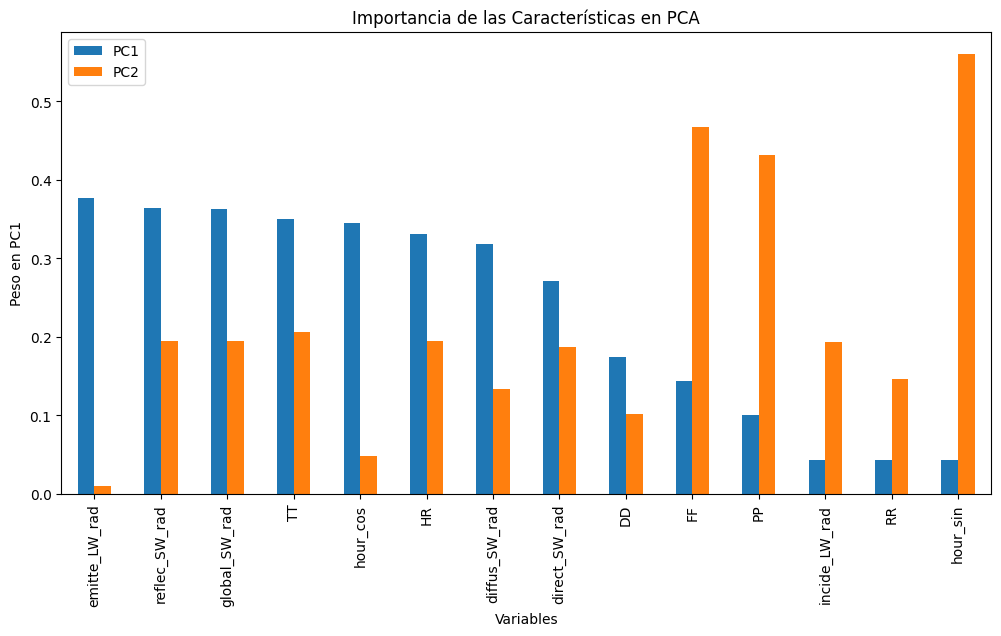

In [49]:
# Normalizar los datos (escalar todas las columnas)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final)

# Aplicar PCA
pca = PCA(n_components=min(df_scaled.shape))  # Número máximo de componentes
pca.fit(df_scaled)

# Obtener la importancia de cada característica
importance = np.abs(pca.components_[:2])  # Tomamos las primeras 2 componentes principales

# Convertir en DataFrame para visualización
columns = df_final.columns
importance_df = pd.DataFrame(importance.T, index=columns, columns=['PC1', 'PC2'])

# Ordenar por relevancia en la primera componente principal
importance_df = importance_df.sort_values(by='PC1', ascending=False)

# Mostrar las variables más influyentes
print(importance_df.head(10))  # Muestra las 10 más relevantes

# Graficar la importancia de las características
importance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Importancia de las Características en PCA')
plt.xlabel('Variables')
plt.ylabel('Peso en PC1')
plt.show()

**Decisión 5:** Se procede a generar una matriz de correlación para eliminar las columnas redundantes. En caso de redundancia (correlación mayor a 0.91), se decide quedarse con las variables más genéricas.

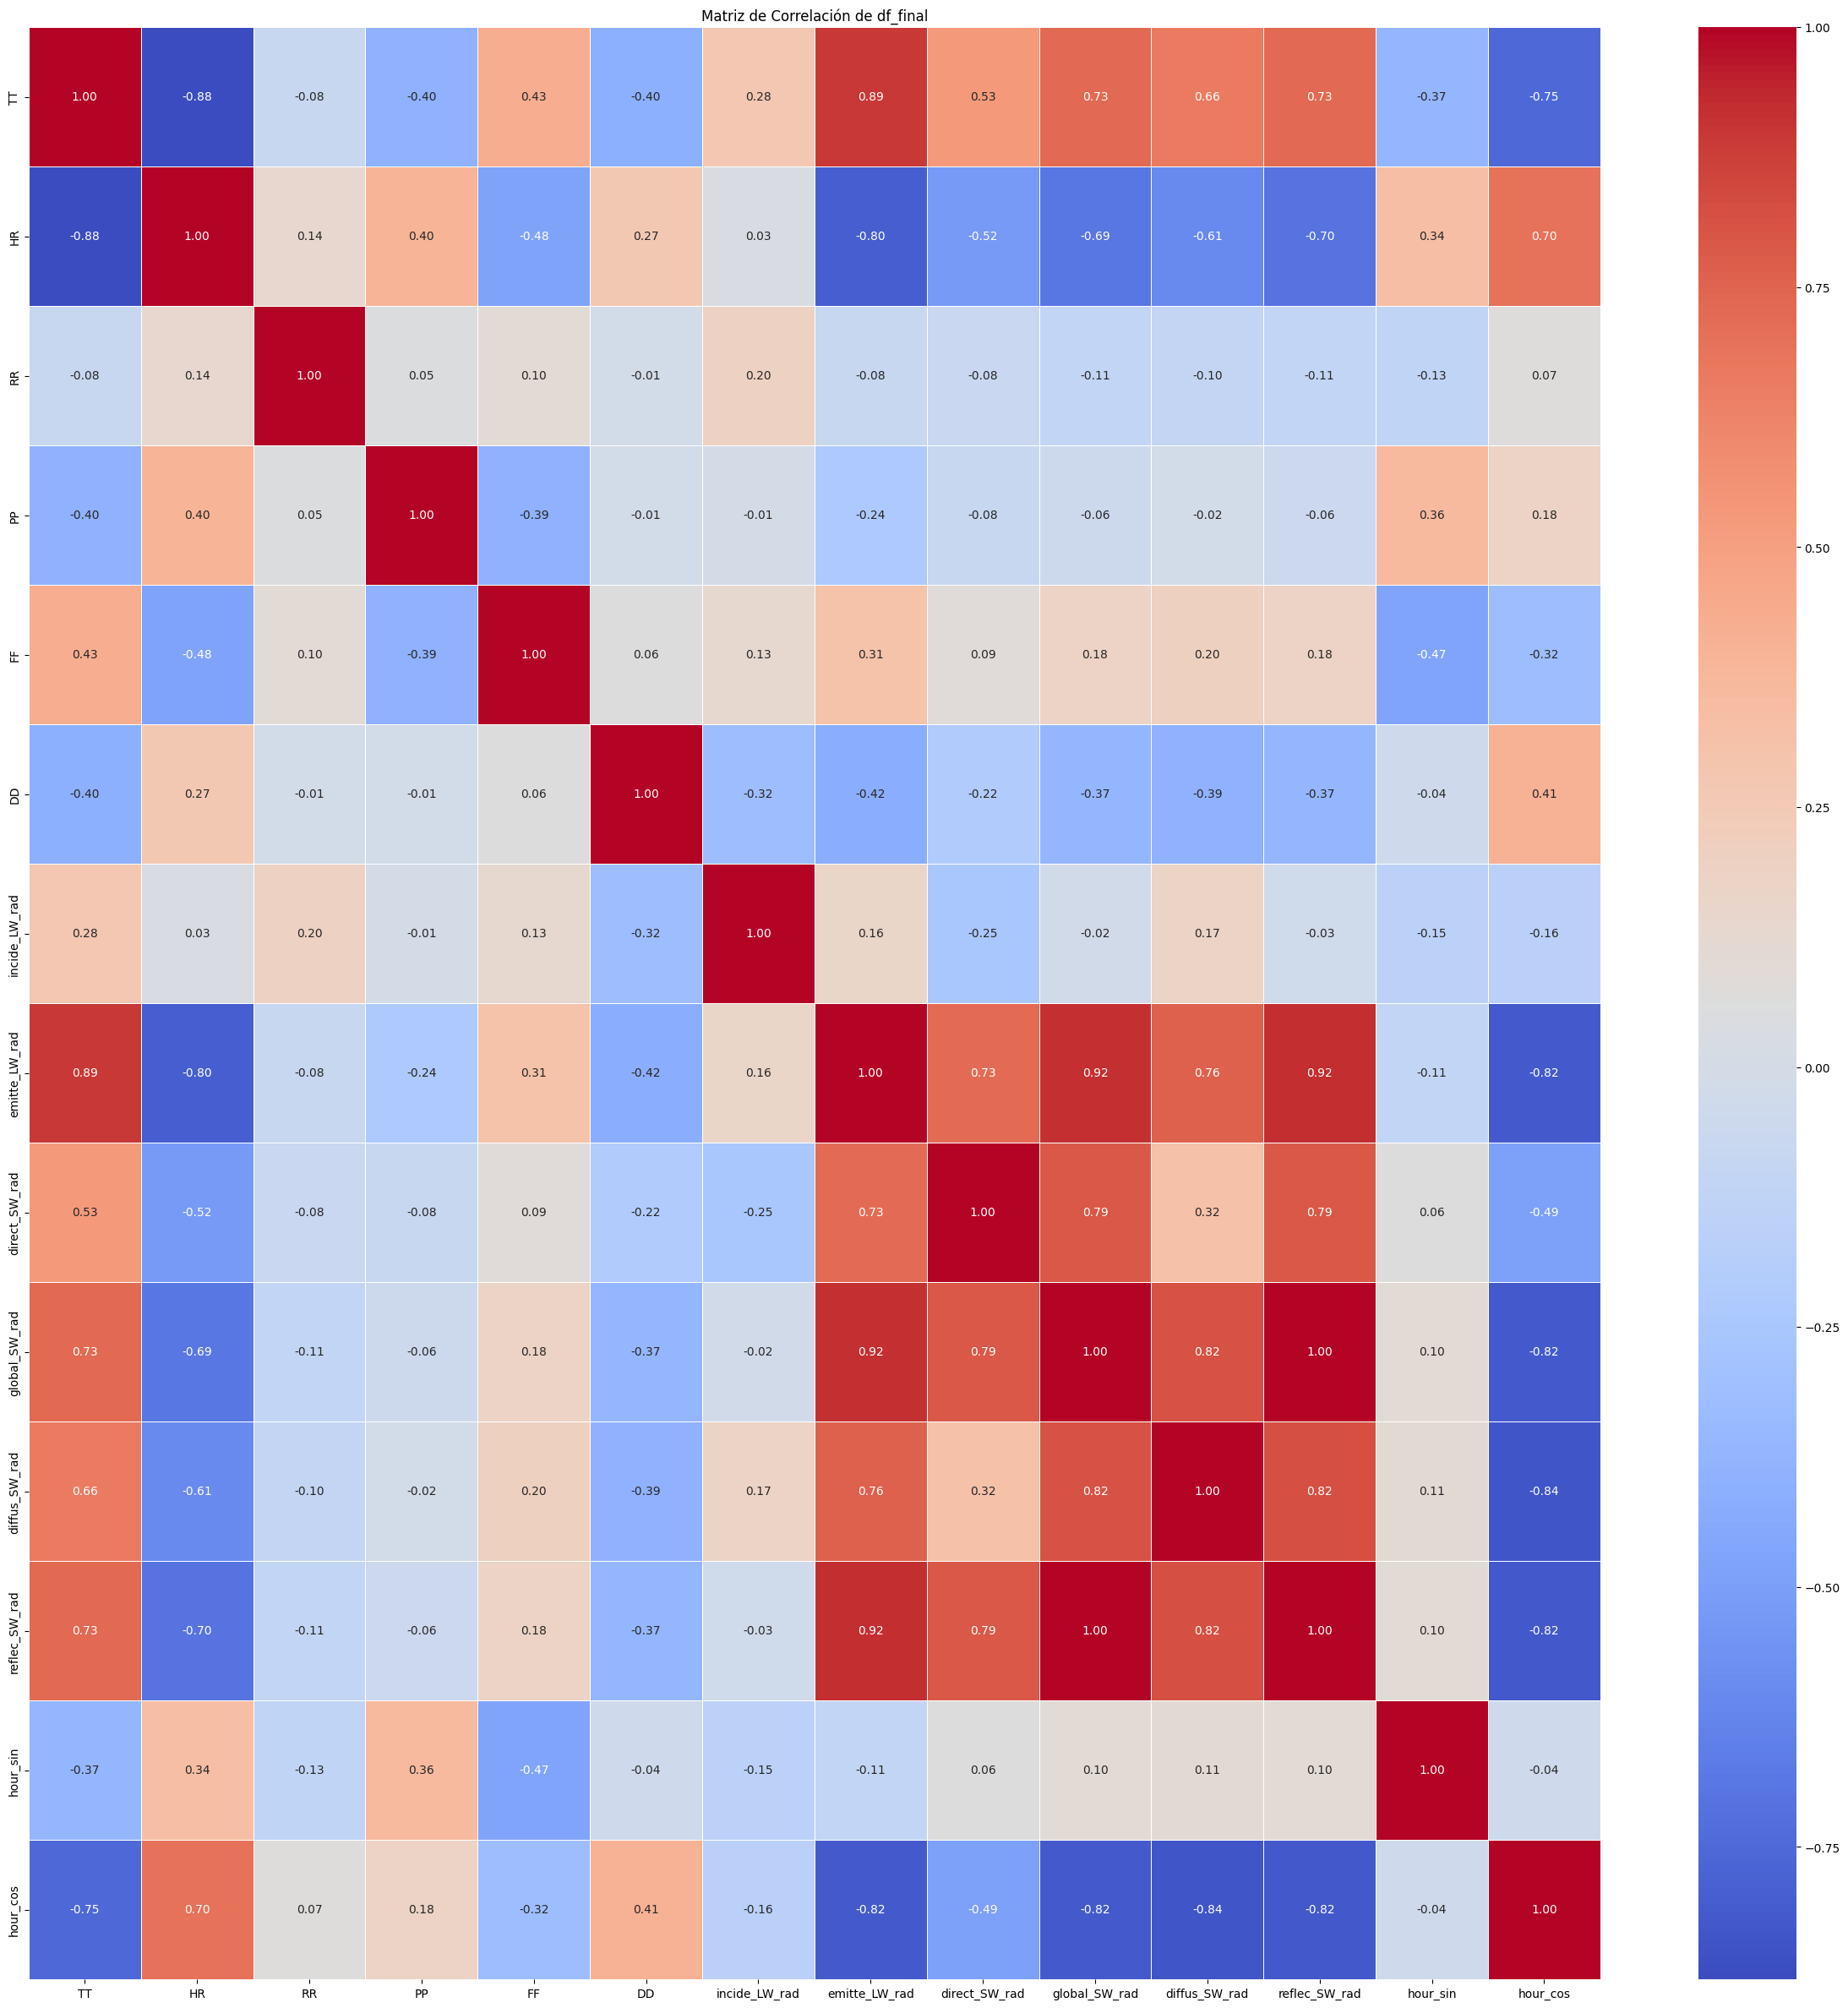

In [50]:
# Calcular la matriz de correlación del df_final
corr_matrix = df_final.corr()

# Graficar el mapa de calor con los valores numéricos
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Guardar el gráfico como imagen
#plt.savefig("matriz_correlacion.png", dpi=300, bbox_inches="tight")

# Mostrar el gráfico
plt.title('Matriz de Correlación de df_final')
plt.show()

In [51]:
redundant_columns = ['reflec_SW_rad','emitte_LW_rad']
df_final.drop(columns=redundant_columns, inplace=True)
df_final.shape

(6684, 12)

##Se procede a entrenar el modelo de regresión lineal
Para el entrenamiento de este modelo solo se tienen en cuenta las filas donde la precipitación sea mayor que 0 por el propósito de ser usado después de haber pasado por un modelo de clasificación.

In [52]:
# Separación  del dataset en atributos (X)  y  target (y)
df_reg_lineal = df_final.copy()
df_cl = df_final.copy()
df_smote = df_final.copy()
df_reg_lineal = df_reg_lineal[df_reg_lineal['RR'] > 0]

y = df_reg_lineal['RR']   #extrae la variable target
X = df_reg_lineal.drop(['RR'], axis=1)  # extrae las variables de entrada (sin target)

#Realizar la división de los datos en subconjuntos
test_size = 0.20    # proporcion de muestras para validacion
seed = 55   # semilla para el generador aleatorio (para reproductibilidad)
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(y_train))
print("Tamaño del conjunto de prueba:", len(y_test))

Tamaño del conjunto de entrenamiento: 568
Tamaño del conjunto de prueba: 143


In [53]:
# Definimos el pool de algoritmos de ML a evaluar
algos = []

algos.append(('LinearReg', LinearRegression()))
algos.append(('Ridge', Ridge()))
algos.append(('Lasso', Lasso()))
algos.append(('ElasticNet', ElasticNet()))
algos.append(('KNN_5', KNeighborsRegressor(n_neighbors=5)))
algos.append(('KNN_10', KNeighborsRegressor(n_neighbors=10)))
algos.append(('RegTrees', DecisionTreeRegressor()))
algos.append(('RegTrees_10', DecisionTreeRegressor(max_depth=10)))

In [54]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 42 # COMPLETAR
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

## Evalua cada algoritmo
for algoname, algo in algos:
    cv_results = cross_val_score(algo, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LinearReg: -1.0721118293758802 (0.622252393276224)
Ridge: -1.071956241248499 (0.6219551619980168)
Lasso: -1.133491863932234 (0.6209515489571593)
ElasticNet: -1.1291570816870027 (0.6046137831909497)
KNN_5: -1.2909678279548873 (0.5492834014969888)
KNN_10: -1.2078870457781956 (0.5693878682769049)
RegTrees: -1.3933232704260654 (0.44188677534674053)
RegTrees_10: -1.6175991250579833 (0.5966198978730141)


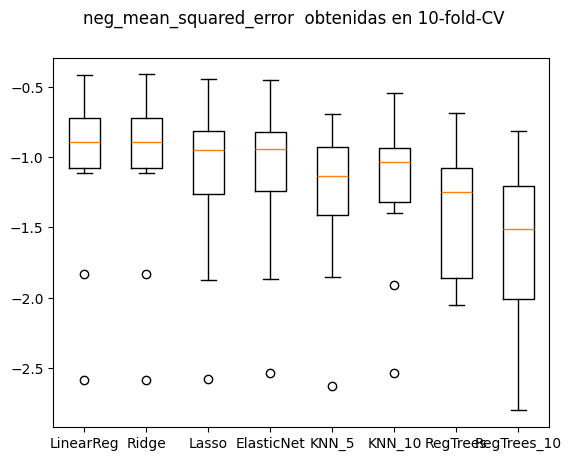

In [55]:
fig = plt.figure()
fig.suptitle('neg_mean_squared_error  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Decisión 6:** Se decide escoger el algoritmo Ridge() para el entrenamiento del modelo porque presenta un valor absoluto de MSE menor que los modelos entrenados con los otros algoritmos.

In [56]:
# Reentrena modelo con todos los datos de entrenamiento y lo prueba en el conjunto de test
model = Ridge()
model.fit(x_train, y_train)
y_predicted = model.predict(x_test)

print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:",explained_variance_score(y_test, y_predicted) )
print("R2 score:", r2_score(y_test, y_predicted))

Mean squared error: 2.151353651496051
Mean absolute error: 0.7970289314212223
Explained variance score: 0.0998257025903333
R2 score: 0.08367128823711412


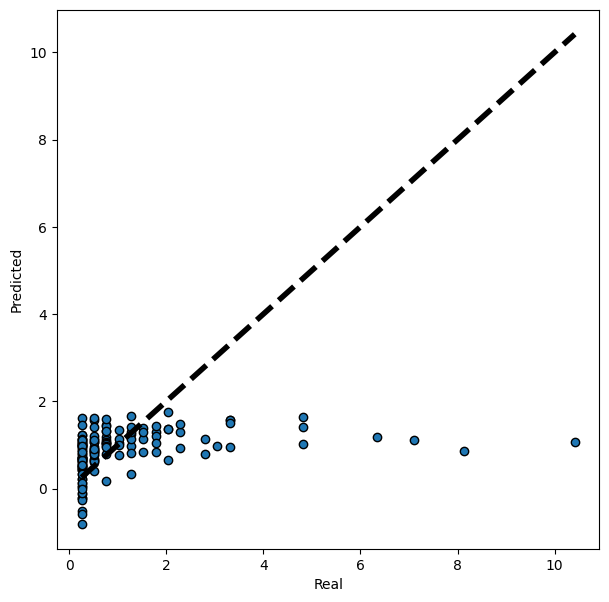

In [57]:
fig, ax = plt.subplots( figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

##Se procede a entrenar el modelo pero ahora haciendo uso de Pipelines
Esto con el fin de probar si así se obtienen mejores resultados usando escaladores

In [58]:
# Definimos el pool de pipleines de ML (escalador + algoritmo de ML) a evaluar
pipelines = []

pipelines.append(('LinearReg', make_pipeline(Normalizer(), LinearRegression())))
pipelines.append(('Ridge', make_pipeline(StandardScaler(), Ridge())))
pipelines.append(('Lasso', make_pipeline(StandardScaler(), Lasso())))
pipelines.append(('ElasticNet', make_pipeline(Normalizer(), ElasticNet())))
pipelines.append(('KNN_5', make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=5))))
pipelines.append(('KNN_10', make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=10))))
pipelines.append(('RegTrees', make_pipeline(RobustScaler(), DecisionTreeRegressor())))
pipelines.append(('RegTrees_10', make_pipeline(RobustScaler(), DecisionTreeRegressor(max_depth=10))))

In [59]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 55
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

## Evalua cada algoritmo
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(pipelinename)
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

LinearReg: -1.0482584472384395 (0.4942033146826856)
Ridge: -1.053242054575159 (0.48928445185783503)
Lasso: -1.208533431208394 (0.5783929300778081)
ElasticNet: -1.208533431208394 (0.5783929300778081)
KNN_5: -1.2117516390676693 (0.42323943284873194)
KNN_10: -1.121618401111529 (0.42425862990563196)
RegTrees: -1.935310221052632 (0.6233394166080352)
RegTrees_10: -2.0520015704005417 (0.8306425217800067)


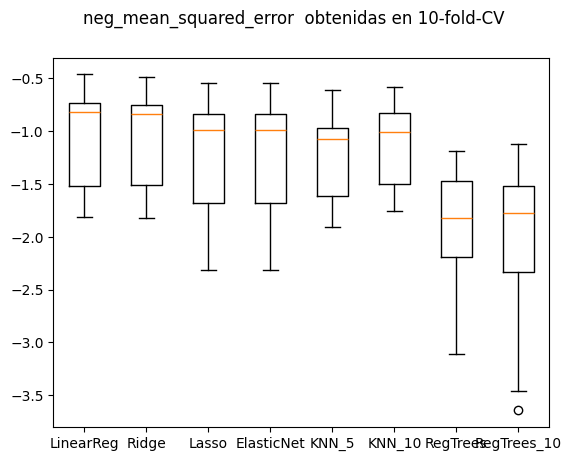

In [60]:
fig = plt.figure()
fig.suptitle('neg_mean_squared_error  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Decisión 7:** Se decide usar el algoritmo de Ridge() con el escalador StandarScaler() porque a pesar de ser los segundos que dan menor valor absoluto de MSE, también poseen menos desviación estándar, es decir son un poco más confiables.

In [61]:
# Reentrena modelo con todos los datos de entrenamiento y lo prueba en el conjunto de test
pipeline = make_pipeline(StandardScaler(), Ridge())
pipeline.fit(x_train, y_train)

y_predicted = pipeline.predict(x_test)

print("Mean squared error:", mean_squared_error(y_test, y_predicted))
print("Mean absolute error:", mean_absolute_error(y_test, y_predicted))
print("Explained variance score:",explained_variance_score(y_test, y_predicted) )
print("R2 score:", r2_score(y_test, y_predicted))

Mean squared error: 2.1502887146155114
Mean absolute error: 0.7969104336050022
Explained variance score: 0.09984637718972023
R2 score: 0.084124878114899


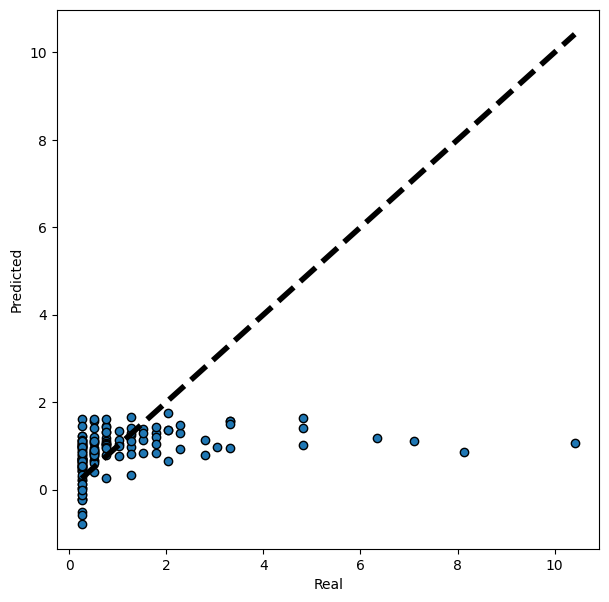

In [62]:
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

##Se procede a entrenar el modelo de clasificación que decidirá si llueve o no
El propósito de esto es que en caso llueva, estos datos pasen al modelo de regresión lineal para predecir la cantidad exacta de profundidad sobre el suelo que causará la precipitación.

In [63]:
df_cl['rain_exists'] = df_cl['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
df_cl.drop(columns='RR', inplace=True)

#extrae la variable target
X = df_cl.drop(['rain_exists'], axis=1)  # extrae las variables de entrada (sin target)
y = df_cl['rain_exists']

#Realizar la división de los datos en subconjuntos
test_size = 0.20
seed = 55   # semilla para el generador aleatorio (para reproductibilidad)
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(y_train))
print("Tamaño del conjunto de prueba:", len(y_test))

Tamaño del conjunto de entrenamiento: 5347
Tamaño del conjunto de prueba: 1337


In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from xgboost import XGBClassifier

algos = []
algos.append(('LogReg', LogisticRegression( solver='liblinear', class_weight='balanced')))  #genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier( n_neighbors=5))) #genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier( n_neighbors=10))) #genera knn con 5 vecinos
algos.append(('CART_none', DecisionTreeClassifier(max_depth=None ,class_weight='balanced'))) # genera DT sin restriccion de profundidad
algos.append(('CART_20', DecisionTreeClassifier(max_depth=20,class_weight='balanced'))) # genera DT sin restriccion de profundidad
algos.append(('XGBClassifier', XGBClassifier()))

In [65]:
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, x_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LogReg: 0.8301612838208194 (0.020825131926119657)
5NN: 0.6170057785699044 (0.029569269311228833)
10NN: 0.5875232090306137 (0.02937642257965912)
CART_none: 0.7053492685501483 (0.027490936560019677)
CART_20: 0.7116590646722414 (0.02703527064808317)
XGBClassifier: 0.7498519112101895 (0.024390409824551117)


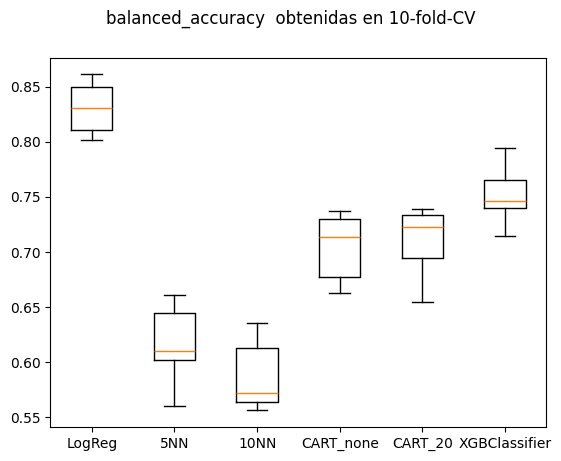

In [66]:
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

##Se procede a mostrar los resultados obtenidos
Tanto con el algoritmo de LogisticRegression y XGBClassifier.

In [67]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard

model = LogisticRegression(solver='liblinear' , class_weight = 'balanced') #  usar class_weight = 'balanced') para entrenar tomando en cuenta el desbalance
model.fit(x_train, y_train)

# predice la clase del conjunto de validacion
y_predicted = model.predict(x_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.8236165949672933

Matriz de Confusión:
[[967 228]
 [ 23 119]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1195
           1       0.34      0.84      0.49       142

    accuracy                           0.81      1337
   macro avg       0.66      0.82      0.69      1337
weighted avg       0.91      0.81      0.84      1337



Se observa que la precisión para predecir cuando llueve es baja, pero el recall es alto, lo cuál es bueno y cumple con el propósito del proyecto.

In [68]:
model = XGBClassifier()
model.fit(x_train, y_train)

# predice la clase del conjunto de validacion
y_predicted = model.predict(x_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.7157286817137133

Matriz de Confusión:
[[1172   23]
 [  78   64]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1195
           1       0.74      0.45      0.56       142

    accuracy                           0.92      1337
   macro avg       0.84      0.72      0.76      1337
weighted avg       0.92      0.92      0.92      1337



El algoritmo XGBClassifier presenta una mayor precisión para predecir cuando llueve, pero su recall tiene casi 50%, lo cual no es tan beneficioso

#Se procede a entrenar el modelo híbrido
Se realiza un split inicial del dataset para separar las variables predictoras (X) de las variables objetivo: una para clasificación (y_cl, que indica si llovió o no) y otra para regresión (y_reg, que representa la cantidad de lluvia transformada logarítmicamente para manejar la abundancia de valores cercanos a 0). Esto se hace para abordar el problema de forma jerárquica, donde primero se predice la ocurrencia de lluvia y, solo en los casos donde se predice lluvia, se estima su cantidad.

In [69]:
df_final['rain_exists'] = df_final['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
df_final['logRR'] = np.log1p(df_final['RR'])

# 2. Variables predictoras y targets para clasificación
X = df_final.drop(columns=['RR', 'rain_exists','logRR'])
y_cl = df_final['rain_exists']
y_reg = df_final['logRR']

# 3. Dividir el dataset (clasificación)
X_train, X_test, y_cl_train, y_cl_test, y_reg_train, y_reg_test = train_test_split(
    X, y_cl, y_reg, test_size=0.30, random_state=42, stratify=y_cl
)

# 4. Entrenar el modelo de clasificación
clf = LogisticRegression(solver='liblinear' , class_weight = 'balanced')
clf.fit(X_train, y_cl_train)

# 5. Predecir en el test
y_cl_pred = clf.predict(X_test)

# 6. Evaluar clasificación
print("Clasificación:")
print("Balanced Accuracy:", balanced_accuracy_score(y_cl_test, y_cl_pred))

# 7. Filtrar solo casos donde se predijo que hay lluvia
X_reg_test = X_test[y_cl_pred == 1]
y_reg_test_true = y_reg_test[y_cl_pred == 1]

# Nota: usamos y_reg_train_full donde hay lluvia real para entrenar regresor
X_reg_train = X_train[y_cl_train == 1]
y_reg_train = y_reg_train[y_cl_train == 1]

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(X_reg_train))
print("Tamaño del conjunto de prueba:", len(X_reg_test))

# 8. Entrenar modelo de regresión solo con datos donde hay lluvia real
reg = make_pipeline(StandardScaler(), Ridge())
reg.fit(X_reg_train, y_reg_train)

# 9. Predecir cantidad de lluvia solo en predicciones positivas
if not X_reg_test.empty:

    y_reg_pred = reg.predict(X_reg_test)
    y_reg_pred = np.expm1(y_reg_pred)
    y_reg_test_true = np.expm1(y_reg_test_true)
    # 10. Evaluar regresión
    print("\nRegresión (solo en casos con lluvia predicha):")
    print("MAE:", mean_absolute_error(y_reg_test_true, y_reg_pred))
    print("MSE:", mean_squared_error(y_reg_test_true, y_reg_pred))
    print("R²:", r2_score(y_reg_test_true, y_reg_pred))
else:
    print("\nNo se predijeron casos con lluvia en el test set.")

df_pred = pd.DataFrame({
    'y_cl_pred': y_cl_pred
}, index=X_test.index)

# Inicializar columna de predicción de regresión con ceros
df_pred['y_reg_pred'] = 0.0

# Si hubo al menos una predicción de lluvia, llenar con valores estimados
if not X_reg_test.empty:
# Asignar predicciones regresivas en las filas donde se predijo lluvia
    df_pred.loc[y_cl_pred == 1, 'y_reg_pred'] = y_reg_pred

# Acceder al vector final respetando los índices originales
y_reg_pred_full = df_pred['y_reg_pred']
y_reg_test = np.expm1(y_reg_test)
print("\nClasificación + regresión:")
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred_full))
print("MSE:", mean_squared_error(y_reg_test, y_reg_pred_full))
print("R²:", r2_score(y_reg_test, y_reg_pred_full))

Clasificación:
Balanced Accuracy: 0.823934497485003
Tamaño del conjunto de entrenamiento: 498
Tamaño del conjunto de prueba: 543

Regresión (solo en casos con lluvia predicha):
MAE: 0.6602746021509608
MSE: 0.8232260484133741
R²: 0.002923195758108177

Clasificación + regresión:
MAE: 0.18467951593617732
MSE: 0.22711484161937293
R²: 0.09571621308688527


Los resultados obtenidos no son los esperados, porque su recall del algoritmo LogisticRegression era el más alto cuando predecía 1. Entonces se esperaba que al unir el modelo de clasificación LogisticRegression con el modelo de regresión lineal Ridge con un StandarScaler se pueda obtener un mayor porcentaje de representación de datos, pero en este caso salió muy cercano a 0, lo que significa que el modelo es muy malo (es casi como usar la media como predicción para este modelo). Por eso se decide descartarlo y usar el segundo mejor algoritmo.

In [70]:
df_final['rain_exists'] = df_final['RR'].apply(lambda x: 0 if x <= 0.0 else 1)
df_final['logRR'] = np.log1p(df_final['RR'])

# 2. Variables predictoras y targets para clasificación
X = df_final.drop(columns=['RR', 'rain_exists','logRR'])
y_cl = df_final['rain_exists']
y_reg = df_final['logRR']

# 3. Dividir el dataset (clasificación)
X_train, X_test, y_cl_train, y_cl_test, y_reg_train, y_reg_test = train_test_split(
    X, y_cl, y_reg, test_size=0.30, random_state=42, stratify=y_cl
)

# 4. Entrenar el modelo de clasificación
clf = XGBClassifier()
clf.fit(X_train, y_cl_train)

# 5. Predecir en el test
y_cl_pred = clf.predict(X_test)

# 6. Evaluar clasificación
print("Clasificación:")
print("Balanced Accuracy:", balanced_accuracy_score(y_cl_test, y_cl_pred))

# 7. Filtrar solo casos donde se predijo que hay lluvia
X_reg_test = X_test[y_cl_pred == 1]
y_reg_test_true = y_reg_test[y_cl_pred == 1]

# Nota: usamos y_reg_train_full donde hay lluvia real para entrenar regresor
X_reg_train = X_train[y_cl_train == 1]
y_reg_train = y_reg_train[y_cl_train == 1]

# Impresión el tamaño del dataset de entrenamiento y de prueba
print("Tamaño del conjunto de entrenamiento:", len(X_reg_train))
print("Tamaño del conjunto de prueba:", len(X_reg_test))

# 8. Entrenar modelo de regresión solo con datos donde hay lluvia real
reg = make_pipeline(StandardScaler(), Ridge())
reg.fit(X_reg_train, y_reg_train)

# 9. Predecir cantidad de lluvia solo en predicciones positivas
if not X_reg_test.empty:

    y_reg_pred = reg.predict(X_reg_test)
    y_reg_pred = np.expm1(y_reg_pred)
    y_reg_test_true = np.expm1(y_reg_test_true)
    # 10. Evaluar regresión
    print("\nRegresión (solo en casos con lluvia predicha):")
    print("MAE:", mean_absolute_error(y_reg_test_true, y_reg_pred))
    print("MSE:", mean_squared_error(y_reg_test_true, y_reg_pred))
    print("R²:", r2_score(y_reg_test_true, y_reg_pred))
else:
    print("\nNo se predijeron casos con lluvia en el test set.")

df_pred = pd.DataFrame({
    'y_cl_pred': y_cl_pred
}, index=X_test.index)

# Inicializar columna de predicción de regresión con ceros
df_pred['y_reg_pred'] = 0.0

# Si hubo al menos una predicción de lluvia, llenar con valores estimados
if not X_reg_test.empty:

    # Asignar predicciones regresivas en las filas donde se predijo lluvia
    df_pred.loc[y_cl_pred == 1, 'y_reg_pred'] = y_reg_pred

# Acceder al vector final respetando los índices originales
y_reg_pred_full = df_pred['y_reg_pred']
y_reg_test = np.expm1(y_reg_test)
print("\nClasificación + regresión:")
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred_full))
print("MSE:", mean_squared_error(y_reg_test, y_reg_pred_full))
print("R²:", r2_score(y_reg_test, y_reg_pred_full))


Clasificación:
Balanced Accuracy: 0.7373929391556627
Tamaño del conjunto de entrenamiento: 498
Tamaño del conjunto de prueba: 147

Regresión (solo en casos con lluvia predicha):
MAE: 0.858106719047044
MSE: 1.9534813808753446
R²: 0.08989580935995156

Clasificación + regresión:
MAE: 0.08896594601192197
MSE: 0.16984548503922015
R²: 0.3237407238283293


**Decisión 8:** Se decide usar el algoritmo XGBClassifier porque este provee una mejor representación de datos y las medidas de errores también son bajas.

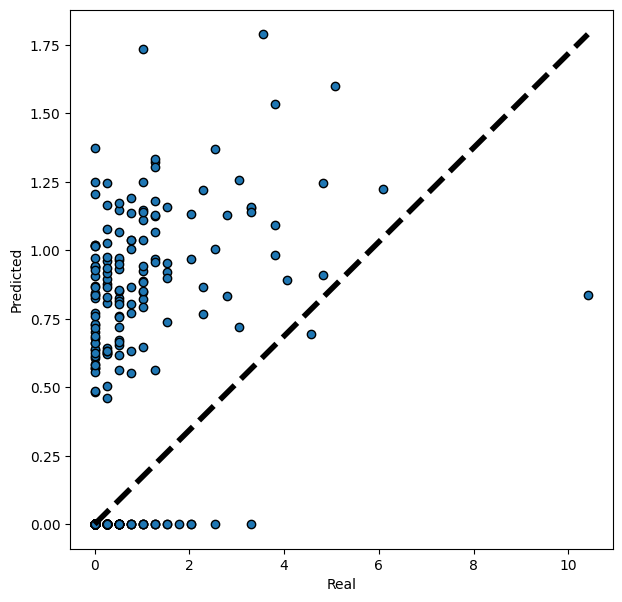

In [71]:
fig, ax = plt.subplots(figsize=[7,7])
ax.scatter(y_reg_test, y_reg_pred_full, edgecolors=(0, 0, 0))
ax.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_pred_full.min(), y_reg_pred_full.max()], 'k--', lw=4)
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()


#Se procede a realizar un modelo que considere balanceo de clases.
Debido a los malos resultados obtenidos con el modelo híbrido, se ha propuesto un nuevo modelo de clasificación con las clases balanceadas para mejorar la capacidad del modelo de detectar correctamente los casos de lluvia. Para lograr dicho balanceo, se utiliza la técnica SMOTE (Synthetic Minority Over-sampling Technique), la cual genera ejemplos sintéticos de la clase minoritaria (en este caso, los días con lluvia) mediante interpolación entre observaciones cercanas en el espacio de características.

Esta técnica permite al modelo de clasificación aprender mejor los patrones asociados a la ocurrencia de lluvia, al presentarle un conjunto de entrenamiento más equilibrado, lo cual reduce el sesgo hacia la clase mayoritaria (días sin lluvia) y mejora métricas como el recall o balanced accuracy.

Se declaran tres niveles de intensidad de lluvia (0: Sin lluvia, 1: Lluvia ligera, 2: Lluvia moderada/fuerte). No hay una clase para el nivel Fuerte porque habían muy pocos registros de lluvia fuerte (solo 3 casos que sobrepasan los 7.5 mm de precipitación).

In [72]:
print(df_smote['RR'].value_counts())
bins = [0, 0.001, 2.5, np.inf]
labels = [0, 1, 2] #sin lluvia, ligera, moderada/fuerte
df_smote['rain_intensity'] = pd.cut(df_smote['RR'], bins=bins, labels=labels, right=False)
df_smote.drop(columns='RR', inplace=True)

RR
0.000     5973
0.254      312
0.508      111
0.762       59
1.016       51
1.270       37
1.524       20
1.778       20
2.032       17
2.794       13
2.540       12
2.286       12
3.302       10
3.810        6
3.556        5
3.048        5
4.826        4
4.064        2
5.080        2
4.572        2
7.112        1
6.096        1
10.414       1
6.604        1
5.842        1
8.128        1
5.588        1
6.350        1
7.874        1
4.318        1
6.858        1
Name: count, dtype: int64


In [73]:
print(df_smote['rain_intensity'].value_counts())

rain_intensity
0    5973
1     639
2      72
Name: count, dtype: int64


Se prepara un conjunto de entrenamiento balanceado para un problema de clasificación multiclase sobre la variable rain_intensity, que presenta desbalance entre clases. Primero, se realiza la división del dataset antes de balancear. Luego, se emplea un undersampling manual (reducción de la clase mayoritaria) para lograr un conjunto más equilibrado antes de aplicar SMOTE con el fin de evitar generar muchos datos sintéticos de las clases minoritarias.

In [74]:
from collections import Counter

# Paso 1: Split antes de balancear
X = df_smote.drop('rain_intensity', axis=1)
y = df_smote['rain_intensity']

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

# Paso 2: Combinar X_train e y_train para aplicar undersampling
df_train = X_train.copy()
df_train['rain_intensity'] = y_train

# Paso 3: Undersampling manual SOLO sobre df_train
df_0 = df_train[df_train['rain_intensity'] == 0].sample(n=3700, random_state=42)
df_1 = df_train[df_train['rain_intensity'] == 1]
df_2 = df_train[df_train['rain_intensity'] == 2]

df_train_bal = pd.concat([df_0, df_1, df_2], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Paso 4: Separar nuevamente X_train e y_train balanceados
x_train = df_train_bal.drop('rain_intensity', axis=1)
y_train = df_train_bal['rain_intensity']

print("Distribución de los datos de entrenamiento:")
print(Counter(y_train))
print("Distribución de los datos de prueba:")
print(Counter(y_test))

Distribución de los datos de entrenamiento:
Counter({0: 3700, 1: 362, 2: 44})
Distribución de los datos de prueba:
Counter({0: 1195, 1: 128, 2: 14})


Se aplica SMOTE y se realiza un entrenamiento similar al realizado para el modelo de clasificación del modelo híbrido.

In [75]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='not majority', random_state=42)

x_train, y_train = smote.fit_resample(x_train, y_train)

print("Distribución de los datos de entrenamiento con SMOTE:")
print(Counter(y_train))

Distribución de los datos de entrenamiento con SMOTE:
Counter({0: 3700, 1: 3700, 2: 3700})


In [76]:
algos = []
algos.append(('LogReg', LogisticRegression( solver='liblinear', class_weight='balanced')))  #genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier( n_neighbors=5))) #genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier( n_neighbors=10))) #genera knn con 5 vecinos
algos.append(('CART_none', DecisionTreeClassifier(max_depth=None, class_weight='balanced'))) # genera DT sin restriccion de profundidad
algos.append(('CART_20', DecisionTreeClassifier(max_depth=20, class_weight='balanced'))) # genera DT sin restriccion de profundidad
algos.append(('XGBClassifier', XGBClassifier()))

In [77]:
results = []
names = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, x_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))

LogReg: 0.69204888410312 (0.008595096103721153)
5NN: 0.9070583751214304 (0.008965680403852816)
10NN: 0.8823449185906466 (0.0062240397951110376)
CART_none: 0.9225650711361137 (0.005494197160095999)
CART_20: 0.920437864959608 (0.008049491971709783)
XGBClassifier: 0.9729448693206203 (0.005358944025222611)


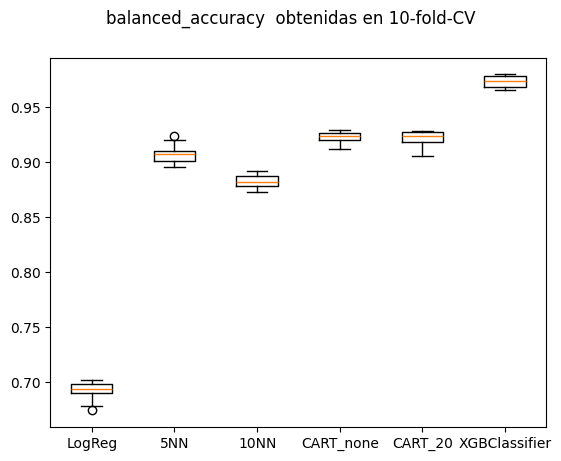

In [78]:
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

**Decisión 9:** Se decide usar el algoritmo LogisticRegression porque es el que presenta mejor balanced_accuracy. Además, es el que mejor predice los casos donde hay una lluvia moderada o fuerte (recall = 0.93), que es lo que más interesa predecir porque el costo de no detectar lluvia moderada o fuerte real (falsos negativos) es más alto que el de una falsa alarma, por lo que maximizar el recall en esas clases es una prioridad.

In [79]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(x_train, y_train)

# predice la clase del conjunto de validacion
y_predicted = model.predict(x_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.7678723973899183

Matriz de Confusión:
[[999 153  43]
 [ 23  69  36]
 [  0   1  13]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1195
           1       0.31      0.54      0.39       128
           2       0.14      0.93      0.25        14

    accuracy                           0.81      1337
   macro avg       0.48      0.77      0.51      1337
weighted avg       0.90      0.81      0.85      1337



Se entrena un modelo que usa el algoritmo XGBClassifier para compararlo con el anterior modelo. Presenta peor balanced_accuracy, por lo que se elige el primer modelo.

In [80]:
model = XGBClassifier()
model.fit(x_train, y_train)

# predice la clase del conjunto de validacion
y_predicted = model.predict(x_test)
print("Balanced Accuracy score:", balanced_accuracy_score(y_test, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_predicted))

Balanced Accuracy score: 0.5371130329746961

Matriz de Confusión:
[[1148   46    1]
 [  57   65    6]
 [   3    9    2]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1195
           1       0.54      0.51      0.52       128
           2       0.22      0.14      0.17        14

    accuracy                           0.91      1337
   macro avg       0.57      0.54      0.55      1337
weighted avg       0.90      0.91      0.91      1337



Se realiza una búsqueda de hiperparámetros para el modelo de regresión logística utilizando GridSearchCV, con el objetivo de optimizar el rendimiento.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10],
        'multi_class': ['multinomial'],
    },
    {
        'solver': ['liblinear'],
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2']
    }
]

grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=100), param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1, verbose=2)
grid.fit(x_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor score:", grid.best_score_)

# Obtener el mejor modelo
best_model = grid.best_estimator_

y_pred = best_model.predict(x_test)
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


Entonces, el mejor modelo que usa LogisticRegression es el que se obtuvo previamente.